In [93]:
test_size=0.33

In [94]:
def refactorData(df):
    maxDisc = df.groupby(["Week Day", "Snapshot Date", "Checkin Date", "Day Diff", "Hotel Name"])[
        "Discount Perc"].max()

    maxDisc = maxDisc.to_frame().reset_index()
    mergedRes = pd.merge(maxDisc, df,
                         left_on=['Week Day', "Snapshot Date", "Checkin Date", "Day Diff", "Hotel Name",
                                  "Discount Perc"],
                         right_on=['Week Day', "Snapshot Date", "Checkin Date", "Day Diff", "Hotel Name",
                                   "Discount Perc"])

    raw_data = mergedRes[['Week Day', "Snapshot Date", "Checkin Date", "Day Diff", "Hotel Name", "Discount Code"]]

    newData = pd.DataFrame()

    newData["Hotel ID"] = raw_data["Hotel Name"].factorize()[0]
    newData["Snapshot Date"] = pd.to_datetime(raw_data["Snapshot Date"]).apply(lambda x: x.toordinal())
    newData["Checkin Date"] = pd.to_datetime(raw_data["Checkin Date"]).apply(lambda x: x.toordinal())
    newData["Week day"] = raw_data["Week Day"].factorize()[0]
    newData["Day Diff"] = raw_data["Day Diff"]
    newData["Discount Code"] = raw_data["Discount Code"]

    return newData

In [95]:
def stats_class(self):
    df = pd.DataFrame(columns=self.classes)

    for cls in self.classes:
        binary_cm = self.binarize(cls)
        binary_cm_stats = binary_cm.stats()
        for key, value in binary_cm_stats.items():
            df.loc[key, cls] = value  # binary_cm_stats

    d_name = {
        'population': 'Population',
        'P': 'P: Condition positive',
        'N': 'N: Condition negative',
        'PositiveTest': 'Test outcome positive',
        'NegativeTest': 'Test outcome negative',
        'TP': 'TP: True Positive',
        'TN': 'TN: True Negative',
        'FP': 'FP',
        'FN': 'FN',
        'TPR': 'TPR: (Sensitivity, hit rate, recall)',
        'TNR': 'TNR=SPC: (Specificity)',
        'PPV': 'PPV: Pos Pred Value (Precision)',
        'NPV': 'NPV: Neg Pred Value',
        'prevalence': 'Prevalence',
        'FPR': 'FPR: False-out',
        'FDR': 'FDR: False Discovery Rate',
        'FNR': 'FNR: Miss Rate',
        'ACC': 'ACC: Accuracy',
        'F1_score': 'F1 score',
        'MCC': 'MCC: Matthews correlation coefficient',
        'informedness': 'Informedness',
        'markedness': 'Markedness',
        'LRP': 'LR+: Positive likelihood ratio',
        'LRN': 'LR-: Negative likelihood ratio',
        'DOR': 'DOR: Diagnostic odds ratio',
        'FOR': 'FOR: False omission rate',
    }
    df.index = df.index.map(lambda id: self._name_from_dict(id, d_name))

    return (df)

In [96]:
def DecisionTreeClass(X_train, X_test, Y_train, Y_test):
    treeModel = DecisionTreeClassifier()

    treeModel.fit(X_train, Y_train)

    treePredicted = treeModel.predict(X_test)
    treeExpected = Y_test

    print("Decision Tree Accuracy:", (metrics.accuracy_score(treeExpected, treePredicted)) * 100)

    treeExpected_arr = treeExpected['Discount Code'].values
    FP_tree, FN_tree = data_stats(treeExpected_arr, treePredicted)

    print("FP = ", FP_tree, " FN = ", FN_tree)

In [97]:
def NaiveBayes(X_train, X_test, Y_train, Y_test):
    model = GaussianNB()
    model.fit(X_train, Y_train)

    naive_predicted = model.predict(X_test)
    naive_expected = Y_test

    print("Naive Bayes Accuracy:", (metrics.accuracy_score(naive_expected, naive_predicted)) * 100)

    naive_expected_arr = naive_expected['Discount Code'].values
    FP_naive, FN_naive = data_stats(np.array(naive_expected_arr), naive_predicted)

    print("FP = ", FP_naive, " FN = ", FN_naive)

In [112]:
def Roc(rowData, X_raw):
    n_classes = 4
    classifiers = {"ROC Decision tree": (OneVsRestClassifier(DecisionTreeClassifier())),
                   "ROC Naive Bayes": (OneVsRestClassifier(GaussianNB()))}

    for text, classifier in classifiers.items():
        # Binarize the output
        y = np.array(rowData[["Discount Code"]])
        y = y.flatten()

        y = label_binarize(y, classes=[1, 2, 3, 4])

        X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=test_size)

        y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

        # ROC curve, ROC area
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # micro-average ROC curve + ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        # ROC Grpah

        # macro-average ROC curve + ROC area
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= n_classes
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        plt.figure()
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]),
                 color='yellow', linestyle=':', linewidth=4)

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]),
                 color='green', linestyle=':', linewidth=4)
        lw = 2
        colors = cycle(['#561A44', '#8E113F', '#C50A3C', '#FC583C'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                           ''.format(i, roc_auc[i]))

        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(text)
        plt.legend(loc="lower right")
        plt.show()

In [113]:
# Calculate FP, FN, ROC
def data_stats(expected, predicted):
    expected_raw = np.copy(expected)
    predicted_raw = np.copy(predicted)
    confusion_matrix = ConfusionMatrix(expected_raw, predicted_raw)
    df_stats = stats_class(confusion_matrix)
    FP = df_stats[1]['FP'] + df_stats[2]['FP'] + df_stats[3]['FP'] + df_stats[4]['FP']
    FN = df_stats[1]['FN'] + df_stats[2]['FN'] + df_stats[3]['FN'] + df_stats[4]['FN']
    return (FP, FN)

In [114]:
hotels_changed_df = pd.read_csv("Hotels_data_Changed.csv",encoding="utf8")
refactored = refactorData(hotels_changed_df)

In [115]:
X_raw = refactored[["Week day", "Snapshot Date", "Checkin Date", "Day Diff", "Hotel ID"]]
X_train, X_test, Y_train, Y_test = train_test_split(X_raw, refactored[["Discount Code"]], test_size=test_size)

In [116]:
DecisionTreeClass(X_train, X_test, Y_train, Y_test)

Decision Tree Accuracy: 69.9001838718
FP =  11459  FN =  11459


In [117]:
NaiveBayes(X_train, X_test, Y_train, Y_test)

Naive Bayes Accuracy: 36.4775413712


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


FP =  24183  FN =  24183


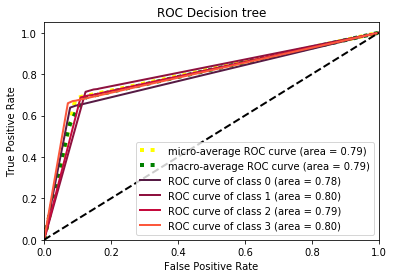

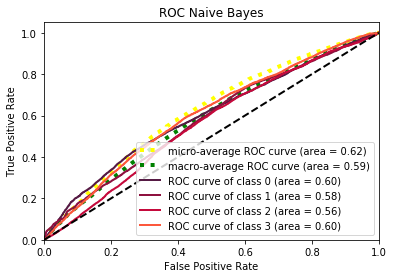

In [118]:
Roc(refactored, X_raw)